- FDW 기능을 사용하려면 적절한 확장을 설치하고 CREATE FOREIGN TABLE , CREATE SERVER 및 CREATE USER MAPPING 과 같은 설정 명령을 실행해야 함

- 적절한 설정을 제공한 후 쿼리 처리 중에 확장에 정의된 함수가 호출되어 외부 테이블에 액세스.



 **FDW의 성능.**

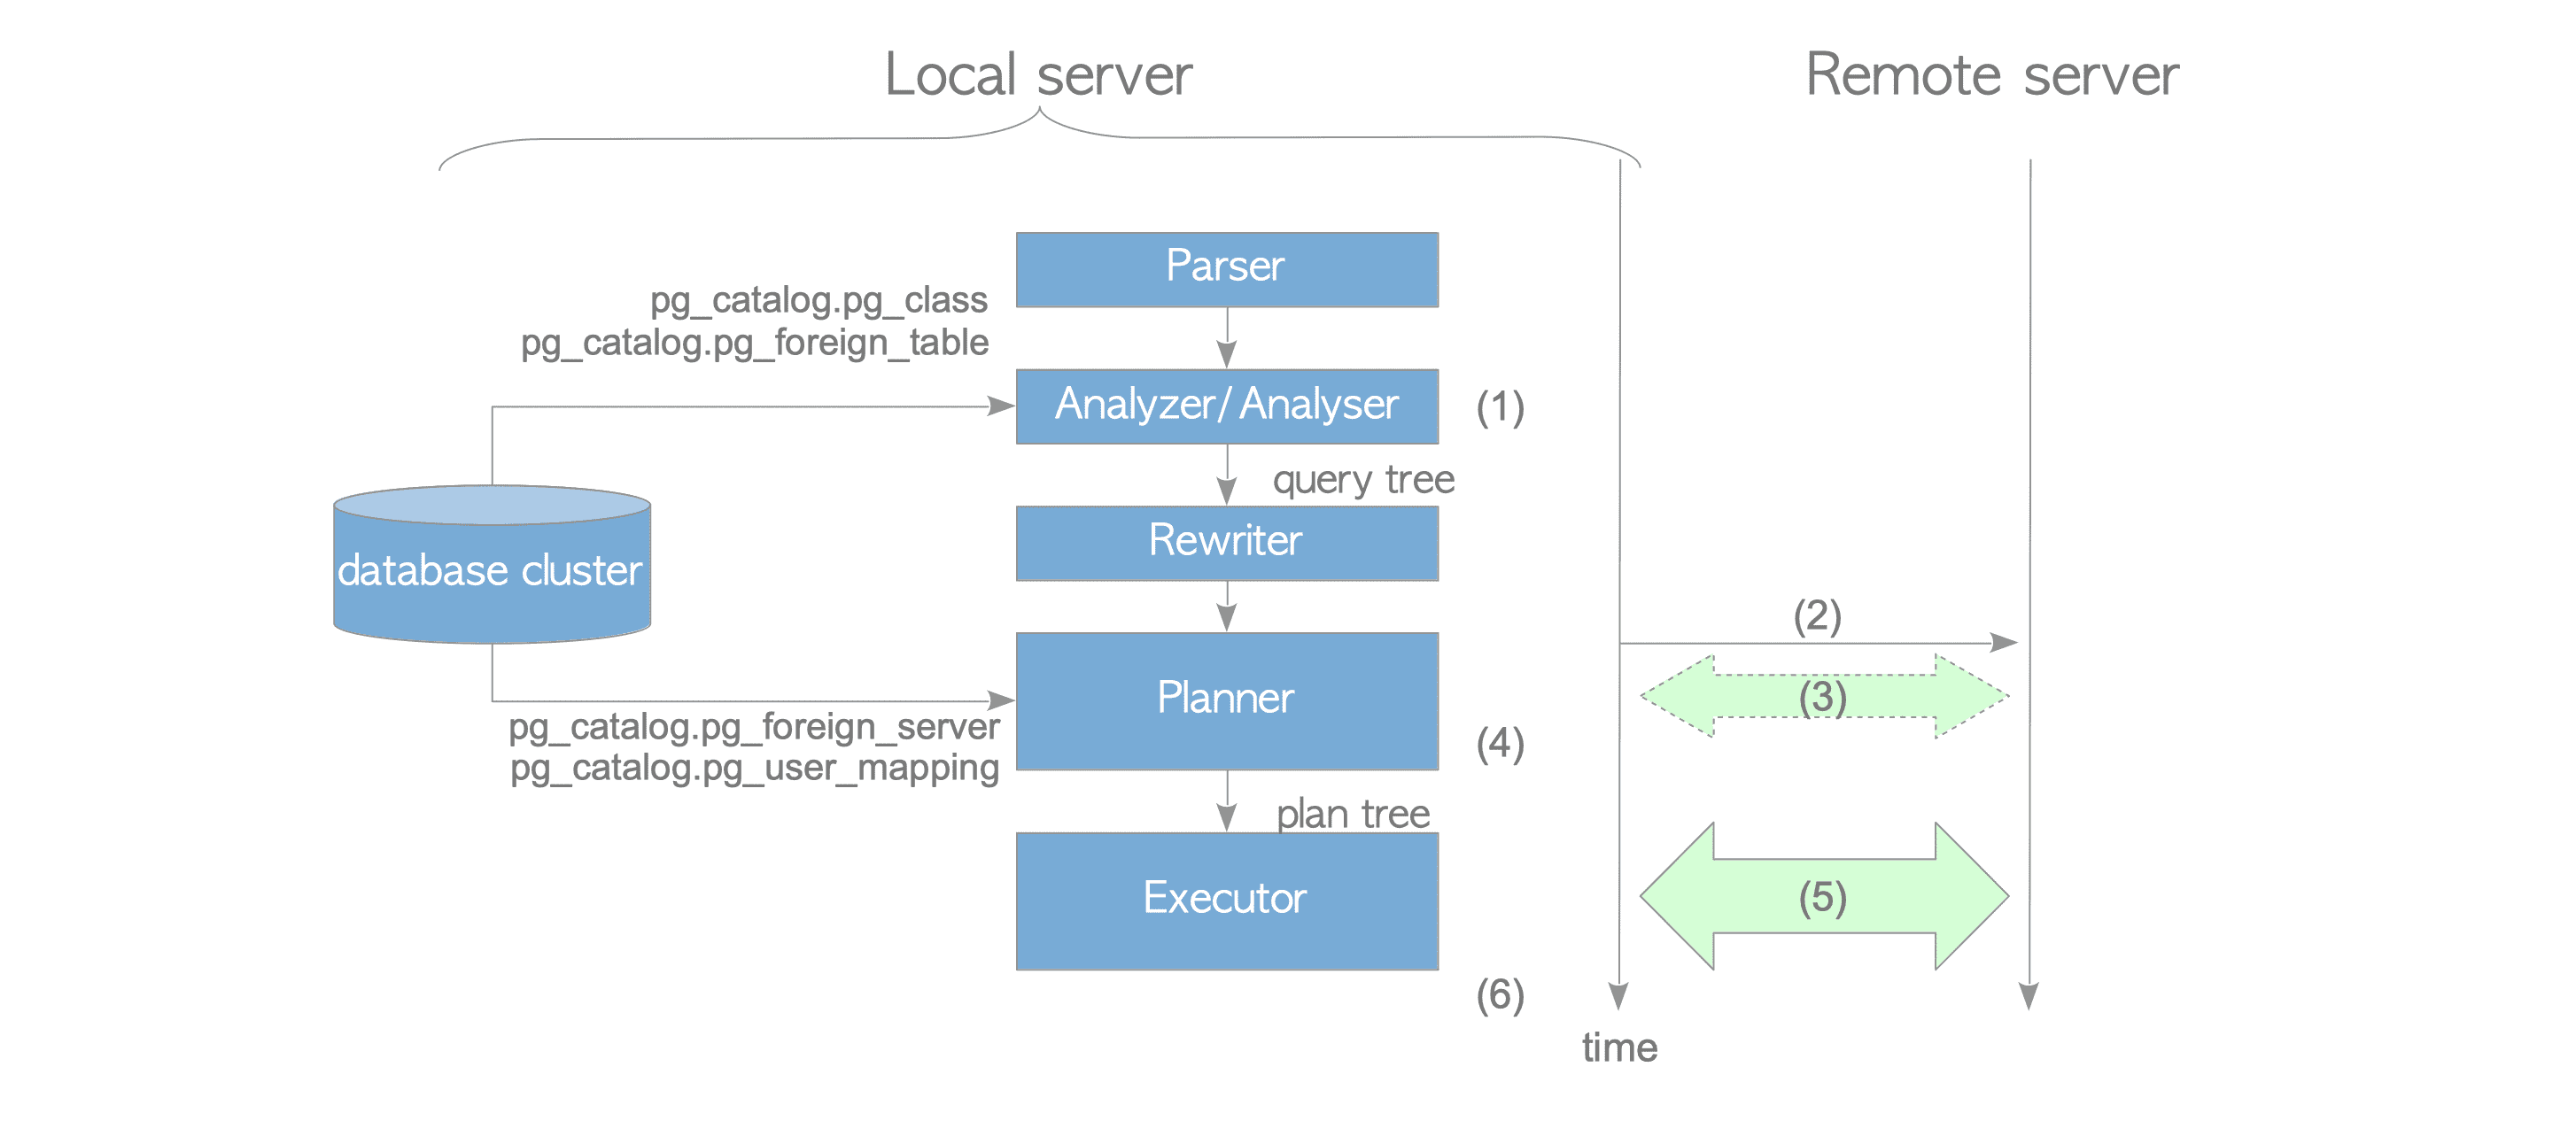

1. 분석기/분석기는 입력 SQL의 쿼리 트리를 생성.
2. 기획자(또는 실행자)가 원격 서버에 접속.
3. use_remote_estimate 옵션이 'on'(기본값은 'off')인 경우 플래너는 EXPLAIN 명령을 실행하여 각 계획 경로의 비용을 추정.
4. 플래너는 계획 트리에서 내부적으로 deparesing 이라고 불리는 일반 텍스트 SQL 문을 생성 .
5. 실행자는 일반 텍스트 SQL 문을 원격 서버로 보내고 그 결과를 받음.
  - 그런 다음 실행기는 필요한 경우 수신된 데이터를 처리. 예를 들어 다중 테이블 질의가 실행되면 실행자는 수신된 데이터와 다른 테이블을 조인 처리.

**쿼리 트리 만들기**

- 분석기/분석기는 CREATE FOREIGN TABLE 또는 IMPORT FOREIGN SCHEMA 명령을 사용하여 pg_catalog.pg_class 및 pg_catalog.pg_foreign_table 카탈로그 에 저장된 외부 테이블의 정의를 사용하여 입력 SQL의 쿼리 트리를 생성.

**원격 서버에 연결**

- 원격 서버에 연결하기 위해 플래너(또는 실행자)는 적절한 라이브러리를 사용하여 원격 데이터베이스 서버에 연결.
  - 예를 들어 원격 PostgreSQL 서버에 연결하기 위해 postgres_fdw는 libpq 라이브러리를 사용.
  - MySQL 서버에 연결하기 위해 EnterpriseDB에서 개발한 mysql_fdw 확장은 libmysqlclient 라이브러리를 사용.

- 사용자 이름, 서버의 IP 주소 및 포트 번호와 같은 연결 매개변수는 CREATE USER MAPPING 및 CREATE SERVER 명령을 사용하여 pg_catalog.pg_user_mapping 및 pg_catalog.pg_foreign_server 카탈로그에 저장.

**EXPLAIN 명령을 사용하여 계획 트리 생성(선택 사항)**

- PostgreSQL의 FDW는 쿼리의 계획 트리를 추정하기 위해 외부 테이블의 통계를 얻는 기능을 지원.
-  postgres_fdw, mysql_fdw, tds_fdw 및 jdbc2_fdw와 같은 일부 FDW 확장은 이러한 통계를 사용.

- ALTER SERVER 명령을 사용하여 use_remote_estimate 옵션을 'on'으로 설정 하면 플래너는 EXPLAIN 명령을 실행하여 원격 서버에 계획 비용을 쿼리.
- 그렇지 않으면 기본적으로 포함된 상수 값이 사용.




```
localdb=# ALTER SERVER remote_server_name OPTIONS (use_remote_estimate 'on');
```

- 일부 확장은 EXPLAIN 명령의 값을 사용하지만 PostgreSQL의 EXPLAIN 명령은 시작 비용과 총 비용을 모두 반환하므로 postgres_fdw만이 EXPLAIN 명령의 결과를 반영할 수 있음.

- EXPLAIN 명령의 결과는 계획을 위해 다른 DBMS FDW 확장에서 사용할 수 없음.
  - 예를 들어, mysql의 EXPLAIN 명령은 예상 행 수만 반환.
  - 그러나 PostgreSQL의 플래너는 비용을 추정하기 위해 더 많은 정보가 필요.

**Deparesing**

- 계획 트리를 생성하기 위해 플래너는 계획 트리의 외부 테이블 스캔 경로에서 일반 텍스트 SQL 문을 생성
  - 예를 들어, 그림은 다음 SELECT 문의 계획 트리를 보여즘.


```
localdb=# SELECT * FROM tbl_a AS a WHERE a.id < 10;
```

- 그림은 PlannedStmt의 계획 트리에서 연결된 ForeignScan 노드가 일반 SELECT 텍스트를 저장하는 것을 보여줌.
- 여기서 postgres_fdw는 구문 분석을 통해 생성된 쿼리 트리에서 일반 SELECT 텍스트를 다시 생성.
  - 이를 PostgreSQL에서는 Deparsing 이라고 함.



**외부 테이블을 스캔하는 계획 트리의 예**

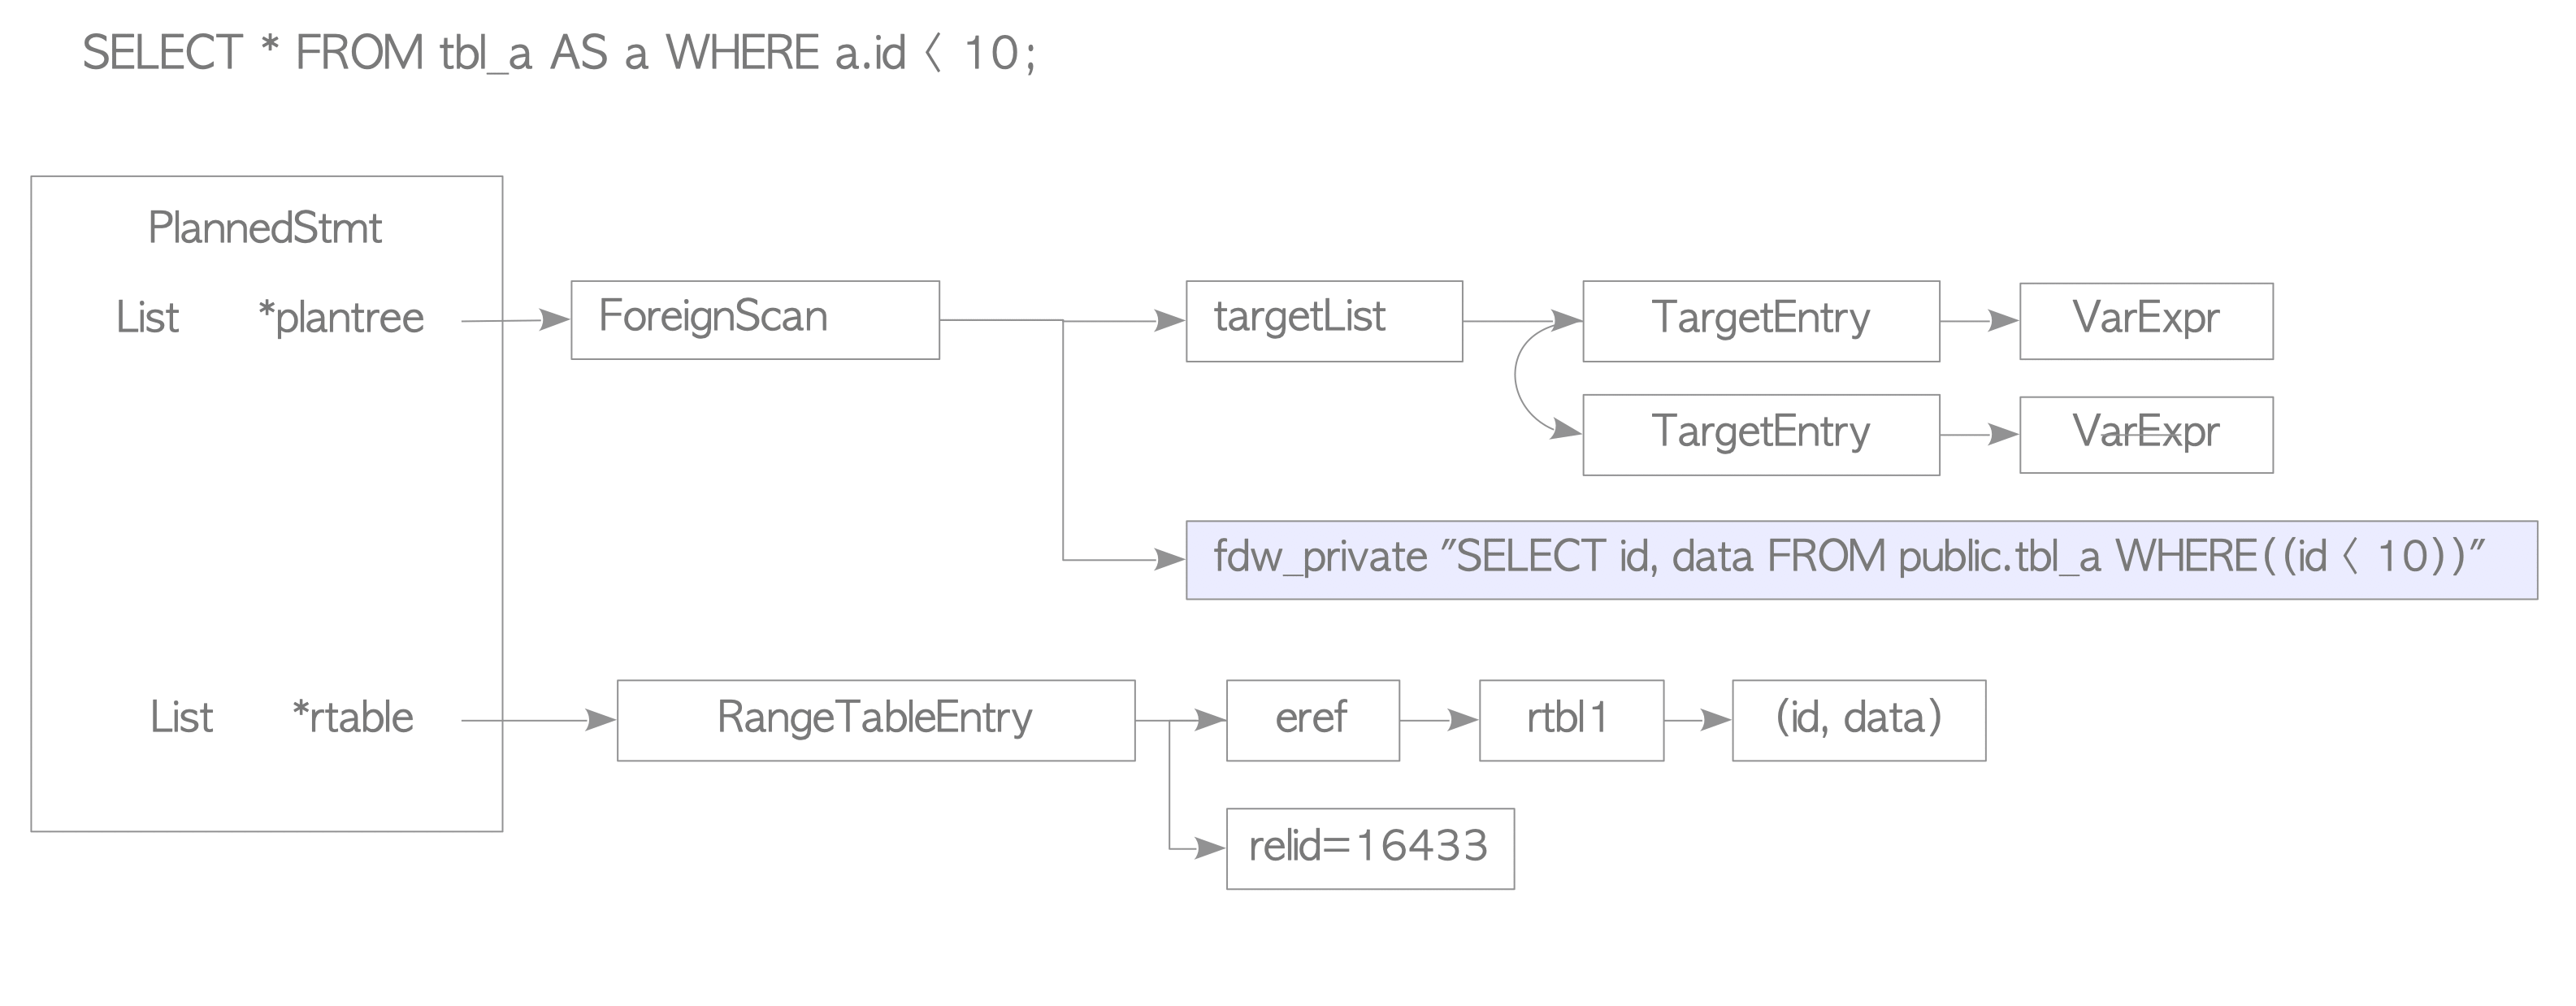

- mysql_fdw를 사용하면 쿼리 트리에서 MySQL용 SELECT 텍스트가 다시 생성.
- redis_fdw 또는 rw_redis_fdw를 사용하면 SELECT 명령이 생성.

**Sending SQL Statements and Receiving Result**
- Deparsing 후 Executor는 Deparsing된 SQL 문을 원격 서버로 보내고 결과를 받음.

- SQL 문을 원격 서버로 보내는 방법은 각 확장 기능의 개발자에 따라 다름.
  - 예를 들어, mysql_fdw는 트랜잭션을 사용하지 않고 SQL 문을 보냄.
  - mysql_fdw에서 SELECT 쿼리를 실행하기 위한 일반적인 SQL 문의 순서는 다음과 같음.



**mysql_fdw에서 SELECT 쿼리를 실행하는 일반적인 SQL 문의 순서**

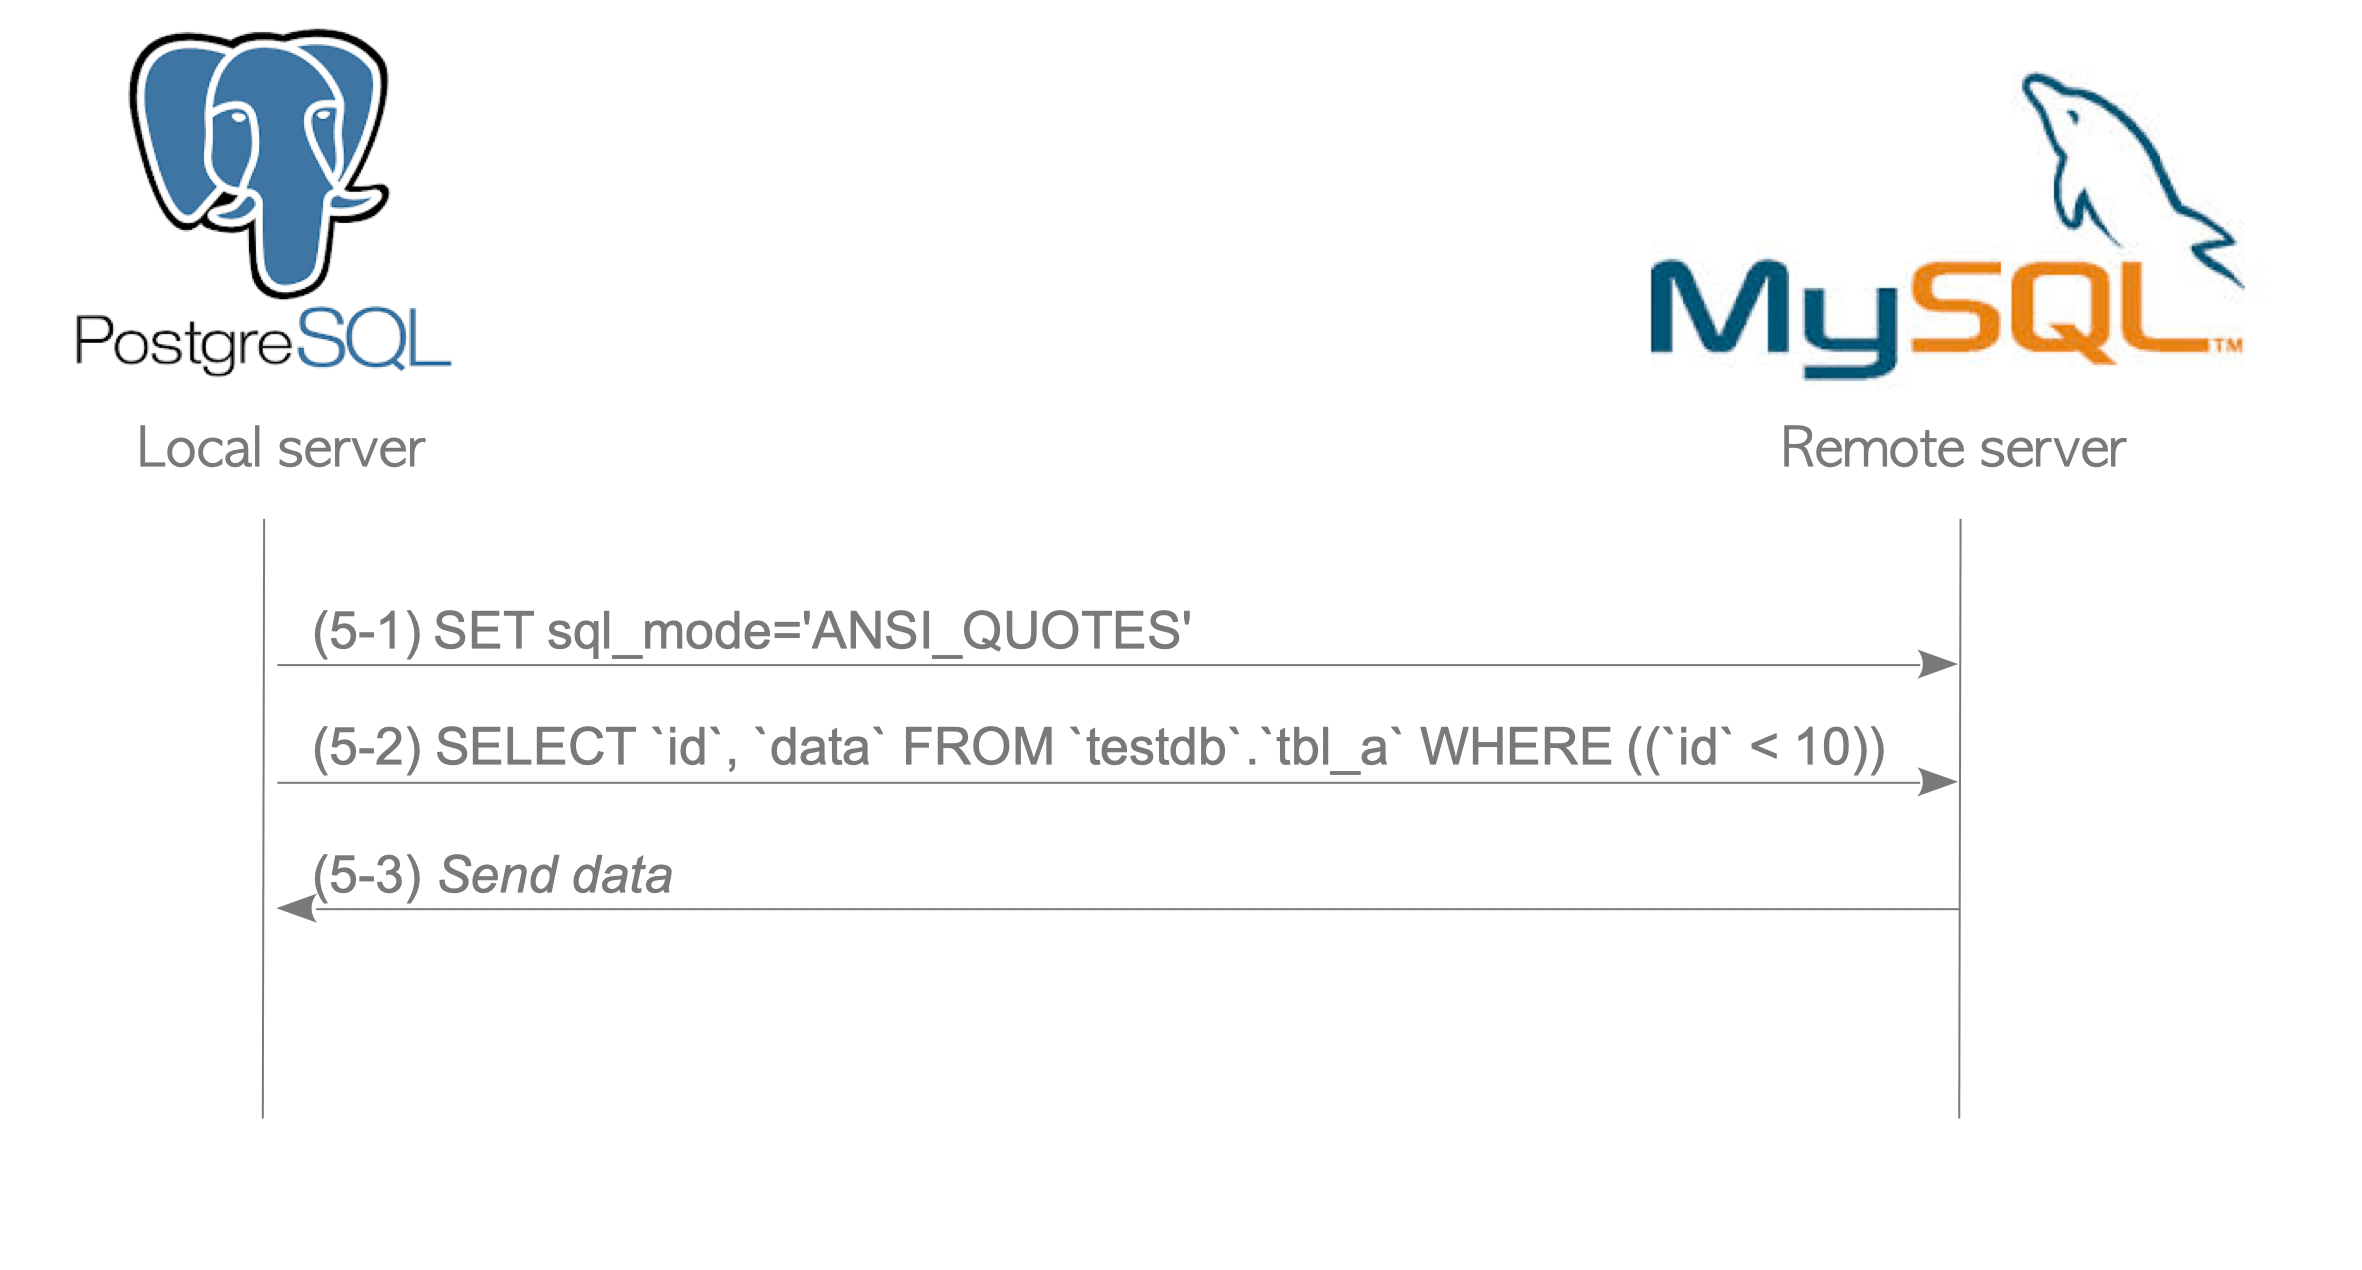

1. SQL_MODE를 'ANSI_QUOTES'로 설정.
2. 원격 서버에 SELECT 문을 보냄.
3. 원격 서버로부터 결과를 받음.
  - 여기서 mysql_fdw는 결과를 PostgreSQL이 읽을 수 있는 데이터로 변환.
  - 모든 FDW 확장은 결과를 PostgreSQL에서 읽을 수 있는 데이터로 변환하는 기능을 구현.

**원격 서버의 실제 로그**

```
mysql> SELECT command_type,argument FROM mysql.general_log;
+--------------+-----------------------------------------------------------------------+
| command_type | argument                                                              |
+--------------+-----------------------------------------------------------------------+
... snip ...

| Query        | SET sql_mode='ANSI_QUOTES'                                            |
| Prepare      | SELECT `id`, `data` FROM `localdb`.`tbl_a` WHERE ((`id` < 10))        |
| Close stmt   |                                                                       |
+--------------+-----------------------------------------------------------------------+
```

- postgres_fdw에서는 SQL 명령 순서가 더 복잡.
- postgres_fdw에서 SELECT 쿼리를 실행하는 일반적인 SQL 문의 순서는 다음과 같음


**postgres_fdw에서 SELECT 쿼리를 실행하는 일반적인 SQL 문의 순서**

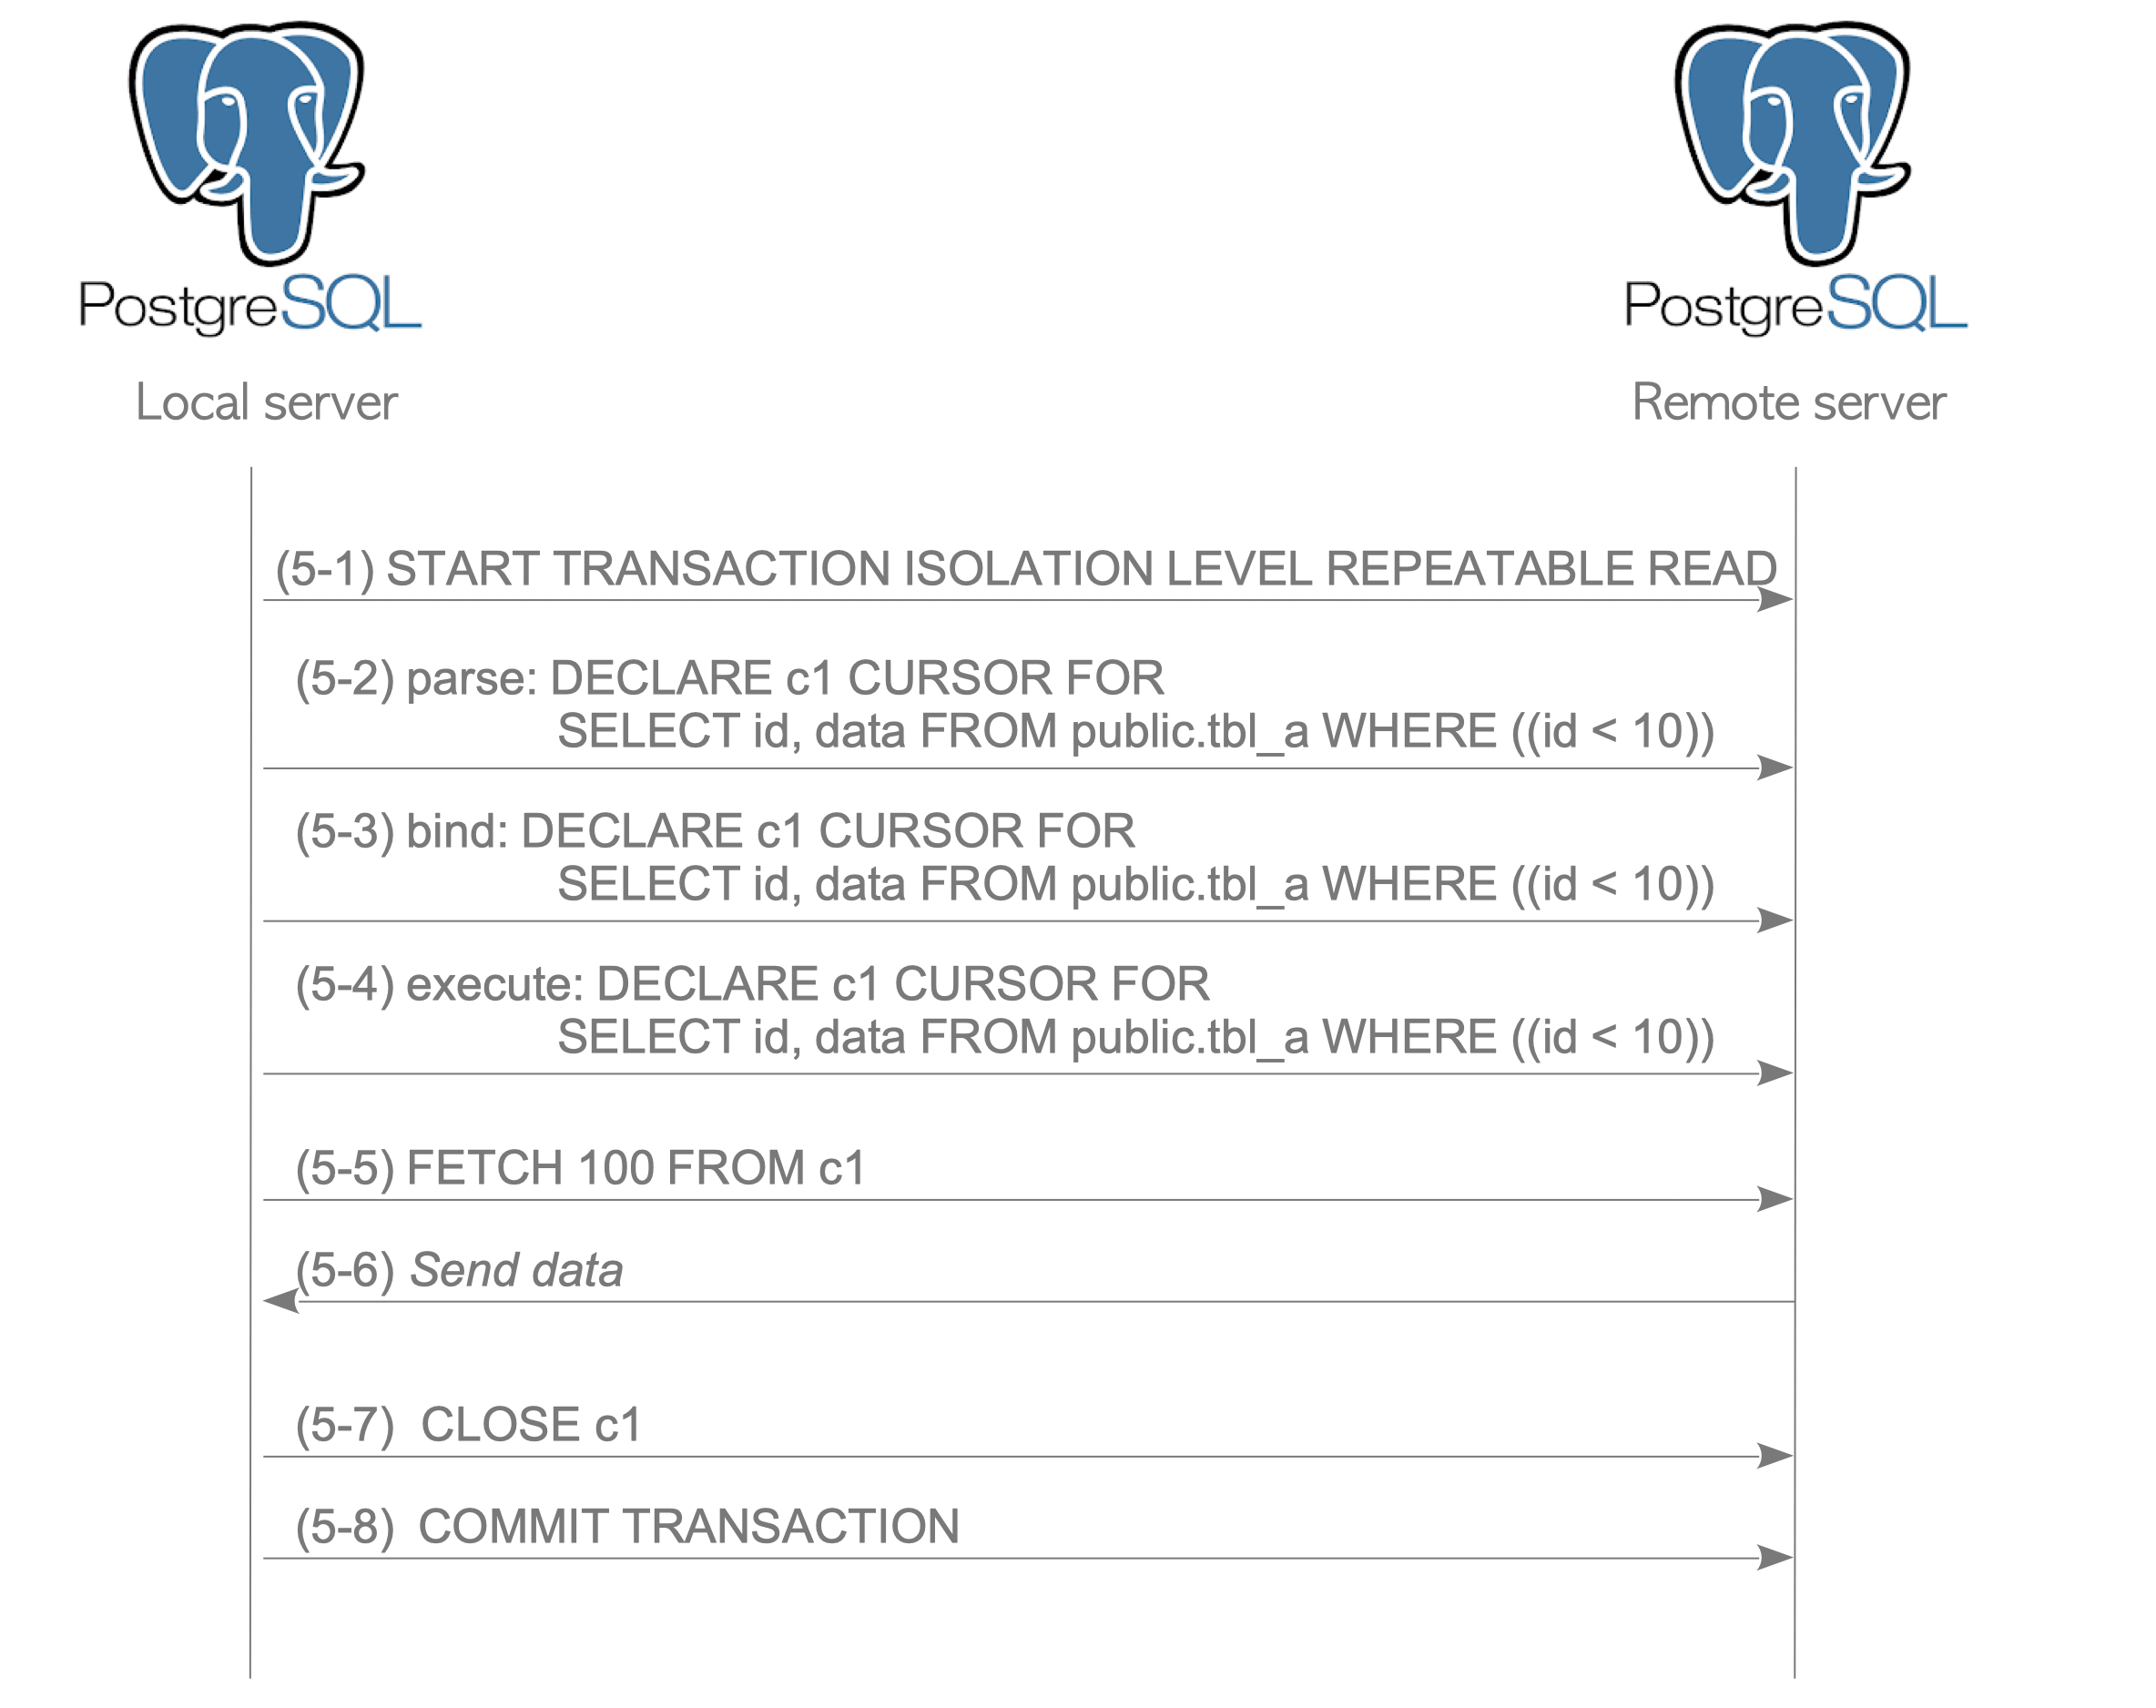

1. 원격 트랜잭션을 시작.
  - 기본 원격 트랜잭션 격리 수준은 REPEATABLE READ. 로컬 트랜잭션의 격리 수준이 SERIALIZABLE로 설정되면 원격 트랜잭션도 SERIALIZABLE로 설정.
2. -4. 커서를 선언.
  - SQL 문은 기본적으로 커서로 실행.
5. FETCH 명령을 실행하여 결과를 얻음.
기본적으로 FETCH 명령으로 100개의 행을 가져옴.
6. 원격 서버로부터 결과를 받음.
7. 커서를 닫음.
8. 원격 트랜잭션을 커밋.

**원격 서버의 실제 로그**


```
LOG:  statement: START TRANSACTION ISOLATION LEVEL REPEATABLE READ
LOG:  parse <unnamed>: DECLARE c1 CURSOR FOR SELECT id, data FROM public.tbl_a WHERE ((id < 10))
LOG:  bind <unnamed>: DECLARE c1 CURSOR FOR SELECT id, data FROM public.tbl_a WHERE ((id < 10))
LOG:  execute <unnamed>: DECLARE c1 CURSOR FOR SELECT id, data FROM public.tbl_a WHERE ((id < 10))
LOG:  statement: FETCH 100 FROM c1
LOG:  statement: CLOSE c1
LOG:  statement: COMMIT TRANSACTION
```

**postgres_fdw의 기본 원격 트랜잭션 격리 수준**

- 로컬 트랜잭션에 SERIALIZABLE 격리 수준이 있는 경우 원격 트랜잭션은 SERIALIZABLE 격리 수준을 사용.
  - 그렇지 않으면 REPEATABLE READ 격리 수준을 사용.
  - 이렇게 선택하면 쿼리가 원격 서버에서 여러 테이블 스캔을 수행하는 경우 모든 스캔에 대해 스냅샷과 일치하는 결과를 얻을 수 있음.
  - 결과적으로 단일 트랜잭션 내의 연속적인 쿼리는 다른 활동으로 인해 원격 서버에서 동시 업데이트가 발생하더라도 원격 서버의 동일한 데이터를 보게 됨.